# Описание проекта

**Описание:** Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача:** обучить модель классифицировать комментарии на позитивные и негативные.

**Цель:** построить модель со значением метрики качества *F1* не меньше 0.75. 

**Ход исследования:**

1. Загрузка и обзор исходных данных
2. Анализ данных
3. TF IDF преобразование текстов
4. BERT (MiniLM) преобразование текстов
5. Обучение нейросети на MiniLM
6. Обучение логистической регрессии
7. Обучение бустинга
8. Отчет

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pip install -q \
    setuptools==59.8.0 \
    wheel \
    numpy \
    pandas \
    scipy \
    matplotlib \
    scikit-learn \
    seaborn \
    torch \
    transformers==4.29.2 \
    huggingface_hub==0.19.4 \
    sentence_transformers==2.2.2 \
    spacy==3.7.2 \
    cffi \
    datasets==2.14.6 \
    accelerate==0.21.0 \
    langid==1.1.6 \
    pyarrow==14.0.2 \
    pandarallel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Загрузка данных
import pandas as pd
import numpy as np

# Предобработка текста
import re
import nltk
from nltk.corpus import stopwords
import spacy

# Анализ данных и графики
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, notebook

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp

# MiniLM / sentence embeddings
from sentence_transformers import SentenceTransformer
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# Модели машинного обучения
import sklearn
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
import torch
import langid
from transformers import EarlyStoppingCallback

W0118 14:12:49.615899 15548 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [4]:
RANDOM_STATE = 101

## Подготовка

In [6]:
data = pd.read_csv("../data/toxic_comments.csv", index_col=0)

In [7]:
data.head(3)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [9]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [10]:
data.duplicated().sum()

0

С данными проблем нет, без дубликатов и пустых (NaN) строк.

## Анализ

Добавим столбец длин текста для удобства анализа

In [12]:
data['text_length'] = data['text'].str.len()
data.describe()

,toxic,text_length
count,159292.000000,159292.000000
mean,0.101612,393.691303
std,0.302139,590.111825
min,0.000000,5.000000
25%,0.000000,95.000000
50%,0.000000,205.000000
75%,0.000000,435.000000
max,1.000000,5000.000000


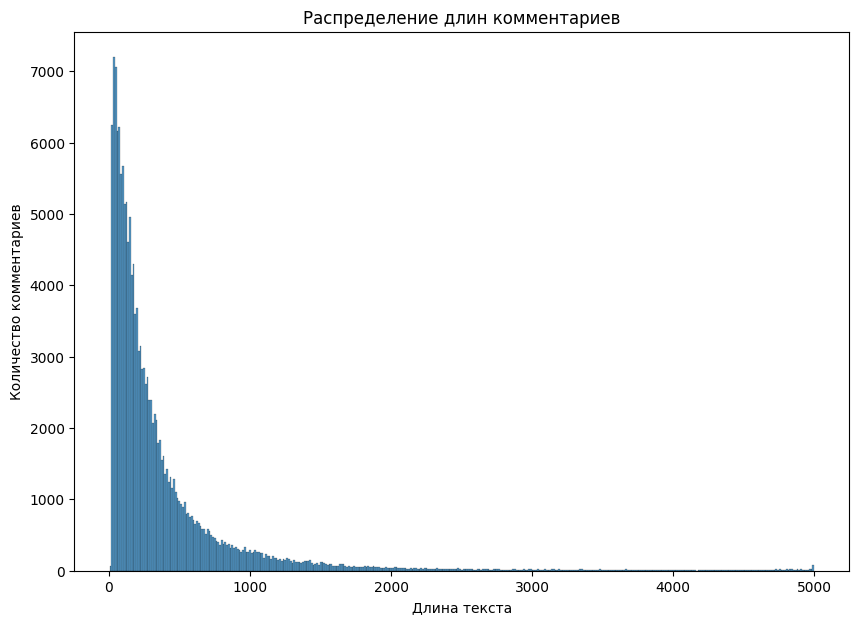

In [13]:
plt.figure(figsize=(10, 7))
sns.histplot(data=data, x='text_length')
plt.xlabel('Длина текста')
plt.ylabel('Количество комментариев')
plt.title('Распределение длин комментариев');

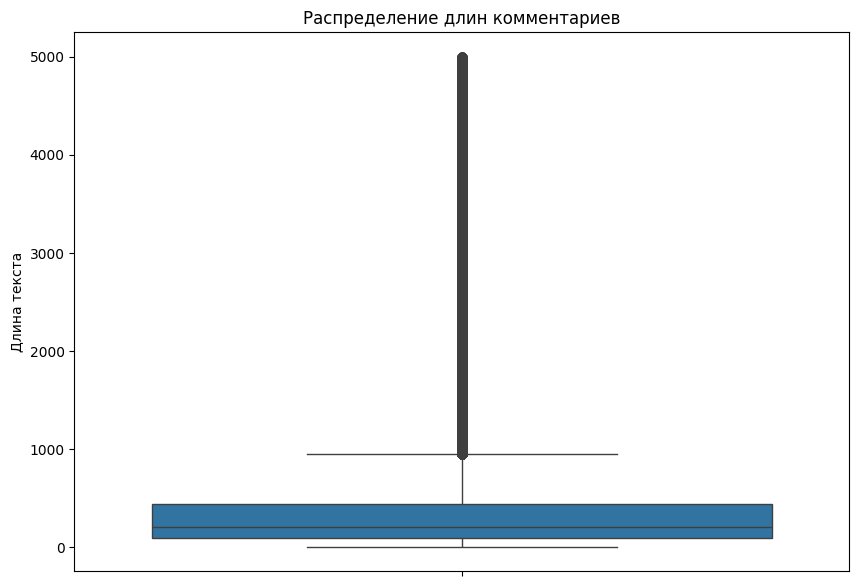

In [14]:
plt.figure(figsize=(10, 7))
sns.boxplot(data['text_length'])
plt.ylabel('Длина текста')
plt.title('Распределение длин комментариев');

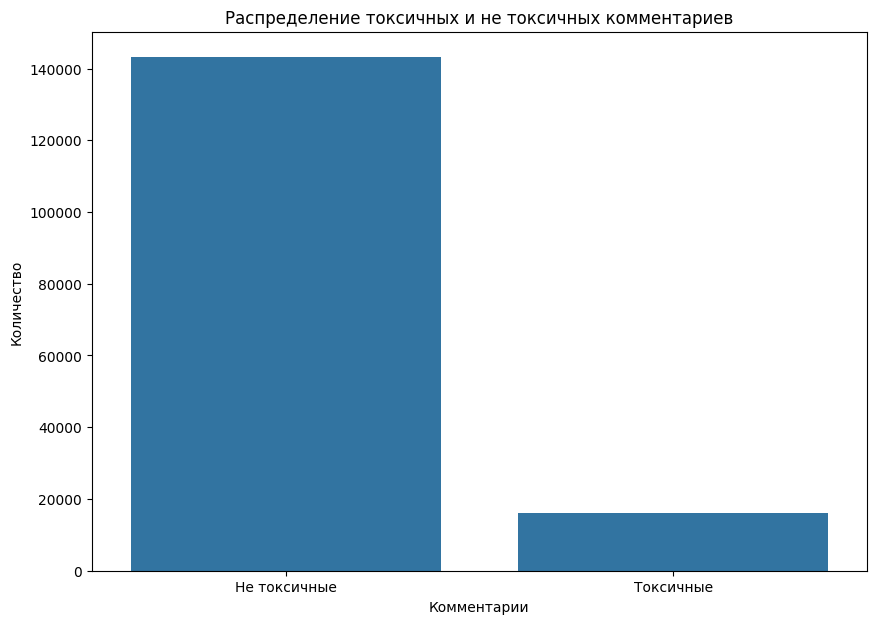

In [15]:
plt.figure(figsize=(10, 7))
sns.countplot(data=data, x='toxic')
plt.title('Распределение токсичных и не токсичных комментариев')
plt.xticks([0, 1], ["Не токсичные", "Токсичные"])
plt.ylabel('Количество')
plt.xlabel('Комментарии')
plt.show()

Большая часть текстов имеет длину 100 - 500 символов. На гистограмме длинный правый хвост, аналогично на боксплоте, распределение логнормальное. Виден сильный дисбаланс токсичных/не токсичных текстов.

## Подготовка данных

In [ ]:
tqdm.pandas()

data["lang"] = data["text"].progress_apply(lambda x: langid.classify(str(x))[0])

data["lang"].value_counts()

100%|██████████| 159292/159292 [04:27<00:00, 595.41it/s]


In [18]:
len(data[data['lang'] == 'en'])/len(data)*100

97.7224217160937

число строк с не английскими словами незначительно, удалим их

In [19]:
data = data[data['lang'] == 'en'].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    data['text'],
    data['toxic'],
    stratify=data['toxic'],
    test_size=0.3,
    random_state=RANDOM_STATE
)

### TF_IDF данные

In [20]:
spacy.require_cpu()

True

In [ ]:
nlp_en = spacy.load("en_core_web_sm")
def preprocess(texts, batch_size, n_process):
    results = []

    cleaned_texts = [" ".join(re.sub('[^a-zA-Z ]', ' ', t).split()) for t in texts]

    for doc in tqdm(nlp_en.pipe(cleaned_texts, batch_size=batch_size, n_process=n_process),
                    total=len(cleaned_texts),
                    desc="Processing texts"):
        lemmatized = " ".join([token.lemma_ for token in doc])
        results.append(lemmatized)

    return results

X_train_preprocessed = preprocess(X_train.tolist(), batch_size=3000, n_process=5)
X_test_preprocessed  = preprocess(X_test.tolist(), batch_size=3000, n_process=5)

print(X_train.iloc[0])
print(X_train_preprocessed[0])

### BERT (MiniLM)

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [ ]:
MODEL_NAME = "all-MiniLM-L6-v2"
model = SentenceTransformer(MODEL_NAME, device=device)

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # убираем html-теги
    text = re.sub(r"<.*?>", " ", text)
    # заменяем переводы строк и табы на пробел
    text = text.replace("\n", " ").replace("\t", " ")
    # несколько пробелов -> один
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess_and_embed(texts, batch_size=512):
    if hasattr(texts, "tolist"):
        texts = texts.tolist()
    
    cleaned_texts = [clean_text(t) for t in texts]

    embeddings = model.encode(
        cleaned_texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    
    return embeddings

X_train_embeddings = preprocess_and_embed(X_train, batch_size=1024)
X_test_embeddings  = preprocess_and_embed(X_test, batch_size=1024)

type(X_train_embeddings)

In [29]:
torch.cuda.empty_cache()

## Обучение

### Нейросеть MiniLM

In [ ]:
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# Длина текстов в токенах, чтобы выбрать для нейросети дальше
token_lengths = []
for text in tqdm(data['text'], desc="Counting tokens"):
    tokens = tokenizer.tokenize(text)
    token_lengths.append(len(tokens))

token_lengths = np.array(token_lengths)

# 90-й перцентиль
p90 = np.percentile(token_lengths, 90)

Counting tokens: 100%|██████████| 155664/155664 [00:30<00:00, 5049.22it/s]


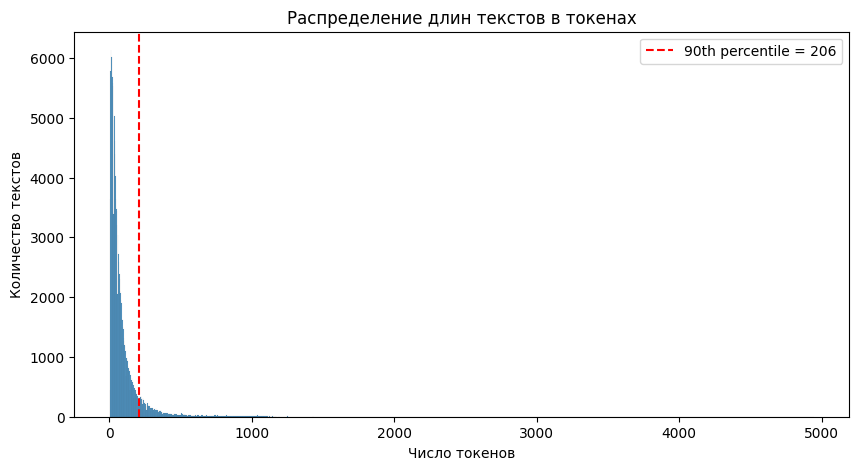

In [32]:
plt.figure(figsize=(10, 5))
sns.histplot(token_lengths)
plt.axvline(p90, color='red', linestyle='--', label=f'90th percentile = {int(p90)}')
plt.xlabel("Число токенов")
plt.ylabel("Количество текстов")
plt.title("Распределение длин текстов в токенах")
plt.legend()
plt.show()

In [73]:
print('Максимальная длина', token_lengths.max())

Максимальная длина 4948


Чтобы покрыть все тексты целиком, нужно установить максимальную длину не менее максимальной длины текста в токенах (512 токенов с лихвой покроют почти все тексты)

In [34]:
BATCH_SIZE = 128
EPOCHS = 3
MAX_LEN = 512

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        item = tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in item.items()}
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {'f1': f1_score(labels, preds)}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=2e-5,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    evaluation_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    logging_steps=50,
    fp16=True
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

train_dataset = TextDataset(X_tr.tolist(), y_tr.tolist())
val_dataset   = TextDataset(X_val.tolist(), y_val.tolist())

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# gradient checkpointing для экономии памяти
model.gradient_checkpointing_enable()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

pred_logits = trainer.predict(val_dataset).predictions
y_pred_val = np.argmax(pred_logits, axis=-1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/2301 [00:00<?, ?it/s]

{'loss': 0.6978, 'learning_rate': 4.3290043290043295e-06, 'epoch': 0.07}
{'loss': 0.5635, 'learning_rate': 8.658008658008659e-06, 'epoch': 0.13}
{'loss': 0.2967, 'learning_rate': 1.2987012987012988e-05, 'epoch': 0.2}
{'loss': 0.1781, 'learning_rate': 1.7316017316017318e-05, 'epoch': 0.26}


  0%|          | 0/86 [00:00<?, ?it/s]

{'eval_loss': 0.14538723230361938, 'eval_f1': 0.743069921390153, 'eval_runtime': 33.0065, 'eval_samples_per_second': 330.147, 'eval_steps_per_second': 2.606, 'epoch': 0.26}
{'loss': 0.1407, 'learning_rate': 1.981642512077295e-05, 'epoch': 0.33}
{'loss': 0.1135, 'learning_rate': 1.9333333333333333e-05, 'epoch': 0.39}
{'loss': 0.114, 'learning_rate': 1.885024154589372e-05, 'epoch': 0.46}
{'loss': 0.0996, 'learning_rate': 1.8367149758454107e-05, 'epoch': 0.52}


  0%|          | 0/86 [00:00<?, ?it/s]

{'eval_loss': 0.08631304651498795, 'eval_f1': 0.8181818181818182, 'eval_runtime': 32.9571, 'eval_samples_per_second': 330.642, 'eval_steps_per_second': 2.609, 'epoch': 0.52}
{'loss': 0.0959, 'learning_rate': 1.7884057971014494e-05, 'epoch': 0.59}
{'loss': 0.103, 'learning_rate': 1.740096618357488e-05, 'epoch': 0.65}
{'loss': 0.0891, 'learning_rate': 1.6917874396135268e-05, 'epoch': 0.72}
{'loss': 0.0849, 'learning_rate': 1.6434782608695655e-05, 'epoch': 0.78}


  0%|          | 0/86 [00:00<?, ?it/s]

{'eval_loss': 0.09511473774909973, 'eval_f1': 0.8213166144200627, 'eval_runtime': 33.063, 'eval_samples_per_second': 329.583, 'eval_steps_per_second': 2.601, 'epoch': 0.78}
{'loss': 0.0924, 'learning_rate': 1.595169082125604e-05, 'epoch': 0.85}
{'loss': 0.0883, 'learning_rate': 1.546859903381643e-05, 'epoch': 0.91}
{'loss': 0.0865, 'learning_rate': 1.4985507246376814e-05, 'epoch': 0.98}
{'loss': 0.0844, 'learning_rate': 1.45024154589372e-05, 'epoch': 1.04}


  0%|          | 0/86 [00:00<?, ?it/s]

{'eval_loss': 0.08050084114074707, 'eval_f1': 0.8252148997134671, 'eval_runtime': 33.2663, 'eval_samples_per_second': 327.568, 'eval_steps_per_second': 2.585, 'epoch': 1.04}
{'loss': 0.0784, 'learning_rate': 1.4019323671497586e-05, 'epoch': 1.11}
{'loss': 0.0819, 'learning_rate': 1.3536231884057973e-05, 'epoch': 1.17}
{'loss': 0.0819, 'learning_rate': 1.3053140096618358e-05, 'epoch': 1.24}
{'loss': 0.0806, 'learning_rate': 1.2570048309178743e-05, 'epoch': 1.3}


  0%|          | 0/86 [00:00<?, ?it/s]

{'eval_loss': 0.08375660330057144, 'eval_f1': 0.8296025582457743, 'eval_runtime': 33.1458, 'eval_samples_per_second': 328.76, 'eval_steps_per_second': 2.595, 'epoch': 1.3}
{'loss': 0.0759, 'learning_rate': 1.208695652173913e-05, 'epoch': 1.37}
{'loss': 0.0759, 'learning_rate': 1.1603864734299517e-05, 'epoch': 1.43}
{'loss': 0.08, 'learning_rate': 1.1120772946859904e-05, 'epoch': 1.5}
{'loss': 0.0699, 'learning_rate': 1.063768115942029e-05, 'epoch': 1.56}


  0%|          | 0/86 [00:00<?, ?it/s]

{'eval_loss': 0.08101986348628998, 'eval_f1': 0.8304038004750594, 'eval_runtime': 33.1003, 'eval_samples_per_second': 329.211, 'eval_steps_per_second': 2.598, 'epoch': 1.56}
{'loss': 0.07, 'learning_rate': 1.0154589371980676e-05, 'epoch': 1.63}
{'loss': 0.0759, 'learning_rate': 9.671497584541065e-06, 'epoch': 1.69}
{'loss': 0.0744, 'learning_rate': 9.18840579710145e-06, 'epoch': 1.76}
{'loss': 0.0794, 'learning_rate': 8.705314009661837e-06, 'epoch': 1.83}


  0%|          | 0/86 [00:00<?, ?it/s]

{'eval_loss': 0.0817912146449089, 'eval_f1': 0.8261665141811528, 'eval_runtime': 33.026, 'eval_samples_per_second': 329.952, 'eval_steps_per_second': 2.604, 'epoch': 1.83}
{'loss': 0.0746, 'learning_rate': 8.222222222222222e-06, 'epoch': 1.89}
{'loss': 0.0755, 'learning_rate': 7.739130434782609e-06, 'epoch': 1.96}
{'loss': 0.0778, 'learning_rate': 7.256038647342996e-06, 'epoch': 2.02}
{'loss': 0.0696, 'learning_rate': 6.7729468599033825e-06, 'epoch': 2.09}


  0%|          | 0/86 [00:00<?, ?it/s]

{'eval_loss': 0.08341512829065323, 'eval_f1': 0.832427536231884, 'eval_runtime': 33.0017, 'eval_samples_per_second': 330.195, 'eval_steps_per_second': 2.606, 'epoch': 2.09}
{'loss': 0.0599, 'learning_rate': 6.2898550724637685e-06, 'epoch': 2.15}
{'loss': 0.0746, 'learning_rate': 5.806763285024155e-06, 'epoch': 2.22}
{'loss': 0.0725, 'learning_rate': 5.3236714975845415e-06, 'epoch': 2.28}
{'loss': 0.0707, 'learning_rate': 4.840579710144928e-06, 'epoch': 2.35}


  0%|          | 0/86 [00:00<?, ?it/s]

{'eval_loss': 0.08025331795215607, 'eval_f1': 0.8353601496725912, 'eval_runtime': 32.9357, 'eval_samples_per_second': 330.856, 'eval_steps_per_second': 2.611, 'epoch': 2.35}
{'loss': 0.0578, 'learning_rate': 4.357487922705314e-06, 'epoch': 2.41}
{'loss': 0.0615, 'learning_rate': 3.8743961352657004e-06, 'epoch': 2.48}
{'loss': 0.0685, 'learning_rate': 3.391304347826087e-06, 'epoch': 2.54}
{'loss': 0.0671, 'learning_rate': 2.9082125603864734e-06, 'epoch': 2.61}


  0%|          | 0/86 [00:00<?, ?it/s]

{'eval_loss': 0.08006461709737778, 'eval_f1': 0.8358633776091081, 'eval_runtime': 32.9895, 'eval_samples_per_second': 330.318, 'eval_steps_per_second': 2.607, 'epoch': 2.61}
{'loss': 0.0696, 'learning_rate': 2.4251207729468603e-06, 'epoch': 2.67}
{'loss': 0.0628, 'learning_rate': 1.9420289855072467e-06, 'epoch': 2.74}
{'loss': 0.0693, 'learning_rate': 1.4589371980676328e-06, 'epoch': 2.8}
{'loss': 0.0647, 'learning_rate': 9.758454106280193e-07, 'epoch': 2.87}


  0%|          | 0/86 [00:00<?, ?it/s]

{'eval_loss': 0.08179210871458054, 'eval_f1': 0.8351137947050628, 'eval_runtime': 32.9833, 'eval_samples_per_second': 330.379, 'eval_steps_per_second': 2.607, 'epoch': 2.87}
{'loss': 0.0638, 'learning_rate': 4.927536231884058e-07, 'epoch': 2.93}
{'loss': 0.0696, 'learning_rate': 9.66183574879227e-09, 'epoch': 3.0}
{'train_runtime': 3838.3428, 'train_samples_per_second': 76.648, 'train_steps_per_second': 0.599, 'train_loss': 0.11048446968683519, 'epoch': 3.0}


  0%|          | 0/86 [00:00<?, ?it/s]

F1 на валидационной части X_train: 0.8358633776091081


In [ ]:
f1_val = f1_score(y_val.tolist(), y_pred_val)
print("F1 на валидационной части X_train:", f1_val)

In [69]:
torch.cuda.empty_cache()

### LogReg

In [37]:
#Диссбаланс классов
y_train.value_counts()

toxic
0    98258
1    10706
Name: count, dtype: int64

In [38]:
#tf-idf данные
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, max_df=0.9)),
    ('logreg', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid = {
    'logreg__class_weight': [{0: 1, 1: w} for w in [1, 2, 3, 5, 9.1]],
    'logreg__C': [1, 3, 5, 7, 10, 15]
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=kf,
    scoring='f1',
    n_jobs=-1
)

In [56]:
grid.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=101, shuffle=True),
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.9, min_df=5)),
                                       ('logreg',
                                        LogisticRegression(random_state=101))]),
             n_jobs=-1,
             param_grid={'logreg__C': [1, 3, 5, 7, 10, 15],
                         'logreg__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                                  {0: 1, 1: 3}, {0: 1, 1: 5},
                                                  {0: 1, 1: 9.1}]},
             scoring='f1')

In [57]:
print('Лучшая модель:', grid.best_params_)
print('Метрика лучшей модели,F1:', round(grid.best_score_, 2))
print('Среднее время обучения, секунды:', round(grid.cv_results_['mean_fit_time'].mean(), 2))
print('Среднее время предсказания, секунды:', round(grid.cv_results_['mean_score_time'].mean(), 2))
print()

Лучшая модель: {'logreg__C': 5, 'logreg__class_weight': {0: 1, 1: 2}}
Метрика лучшей модели,F1: 0.78
Среднее время обучения, секунды: 7.4
Среднее время предсказания, секунды: 1.25



In [ ]:
#эмбединги
param_grid2 = {
    'class_weight': [{0: 1, 1: w} for w in [1, 2, 3, 5, 9.1]],
    'C': [1, 3, 5, 7, 10, 15]
}

grid2 = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid2,
    cv=kf,
    scoring='f1',
    n_jobs=-1
)

In [42]:
grid2.fit(X_train_embeddings, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=101, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 3, 5, 7, 10, 15],
                         'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}, {0: 1, 1: 5},
                                          {0: 1, 1: 9.1}]},
             scoring='f1')

In [43]:
print('Лучшая модель:', grid2.best_params_)
print('Метрика лучшей модели,F1:', round(grid2.best_score_, 2))
print('Среднее время обучения, секунды:', round(grid2.cv_results_['mean_fit_time'].mean(), 2))
print('Среднее время предсказания, секунды:', round(grid2.cv_results_['mean_score_time'].mean(), 2))
print()

Лучшая модель: {'C': 15, 'class_weight': {0: 1, 1: 2}}
Метрика лучшей модели,F1: 0.72
Среднее время обучения, секунды: 12.29
Среднее время предсказания, секунды: 0.2



### LigthGBM

In [44]:
#tf-idf данные
lgbm_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, max_df=0.9)),
    ('lgbm', LGBMClassifier(objective='binary', random_state=RANDOM_STATE))
])

param_search_lgbm = {
        'lgbm__n_estimators': [100, 300, 500],
        'lgbm__learning_rate': [0.01, 0.1, 0.5],
        'lgbm__num_leaves': [16, 32, 64],
        'lgbm__max_depth': [3, 5, 7, 9],
        'lgbm__scale_pos_weight': [1, 2, 3, 5, 9.1]
}

rand_search_lgbm = RandomizedSearchCV(
    estimator = lgbm_pipe,
    param_distributions = param_search_lgbm,
    scoring='f1',
    n_iter=5,
    cv=kf,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [58]:
rand_search_lgbm.fit(X_train_preprocessed, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=101, shuffle=True),
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(max_df=0.9,
                                                              min_df=5)),
                                             ('lgbm',
                                              LGBMClassifier(objective='binary',
                                                             random_state=101))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'lgbm__learning_rate': [0.01, 0.1, 0.5],
                                        'lgbm__max_depth': [3, 5, 7, 9],
                                        'lgbm__n_estimators': [100, 300, 500],
                                        'lgbm__num_leaves': [16, 32, 64],
                                        'lgbm__scale_pos_weight': [1, 2, 3, 5,
                                                                   9.1]},
                   random_state=101, scoring='f1')

In [59]:
print('Лучшая модель:', rand_search_lgbm.best_params_)
print('Метрика лучшей модели,F1:', round(rand_search_lgbm.best_score_, 2))
print('Среднее время обучения, секунды:', round(rand_search_lgbm.cv_results_['mean_fit_time'].mean(), 2))
print('Среднее время предсказания, секунды:', round(rand_search_lgbm.cv_results_['mean_score_time'].mean(), 2))
print()

Лучшая модель: {'lgbm__scale_pos_weight': 3, 'lgbm__num_leaves': 32, 'lgbm__n_estimators': 300, 'lgbm__max_depth': 9, 'lgbm__learning_rate': 0.1}
Метрика лучшей модели,F1: 0.77
Среднее время обучения, секунды: 108.29
Среднее время предсказания, секунды: 1.84



In [ ]:
#эмбединги
param_search_lgbm2 = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.1, 0.5],
        'num_leaves': [16, 32, 64],
        'max_depth': [3, 5, 7, 9],
        'scale_pos_weight': [1, 2, 3, 5, 9.1]
}

rand_search_lgbm2 = RandomizedSearchCV(
    estimator = LGBMClassifier(objective='binary', random_state=RANDOM_STATE),
    param_distributions = param_search_lgbm2,
    scoring='f1',
    n_iter=5,
    cv=kf,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [48]:
rand_search_lgbm2.fit(X_train_embeddings, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=101, shuffle=True),
                   estimator=LGBMClassifier(objective='binary',
                                            random_state=101),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.5],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [100, 300, 500],
                                        'num_leaves': [16, 32, 64],
                                        'scale_pos_weight': [1, 2, 3, 5, 9.1]},
                   random_state=101, scoring='f1')

In [49]:
print('Лучшая модель:', rand_search_lgbm2.best_params_)
print('Метрика лучшей модели,F1:', round(rand_search_lgbm2.best_score_, 2))
print('Среднее время обучения, секунды:', round(rand_search_lgbm2.cv_results_['mean_fit_time'].mean(), 2))
print('Среднее время предсказания, секунды:', round(rand_search_lgbm2.cv_results_['mean_score_time'].mean(), 2))
print()

Лучшая модель: {'scale_pos_weight': 3, 'num_leaves': 32, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1}
Метрика лучшей модели,F1: 0.7
Среднее время обучения, секунды: 108.08
Среднее время предсказания, секунды: 0.53



### Предсказания на тестовых данных

In [70]:
test_dataset = TextDataset(X_test.tolist(), y_test.tolist())

pred_logits_test = trainer.predict(test_dataset).predictions
y_pred_test = np.argmax(pred_logits_test, axis=-1)

f1_test = f1_score(y_test.tolist(), y_pred_test)

  0%|          | 0/365 [00:00<?, ?it/s]

In [71]:
print("F1 на X_test:", round(f1_test, 2))

F1 на X_test: 0.85


In [72]:
torch.cuda.empty_cache()

Итоговое значение метрики на тесте - 0.85

## Выводы

По результатам проделанной работы, было установлено следующее:
- дубликатов и пропусков в данных нет
- преимущественно все тексты на английском языке, около 3% на других языках. Следует на будущее рассмотерть варианты фильтрации по языку, сейчас процент невелик, однако в будущем может быть, что в теме на английском множество комментариев на другом языке
- примено 8.5% текстов имеют длинну более 1000 символов. Возможно, стоит ввести ограничение на максимальную длинну текстов. Для использованной нейросети есть ограничения на максимальный размер текста.

Результаты моделирования показывают:
- нейросеть дает значение метрики выше минимально необходимого, но требует ресурсов для работы.
- логистическая регрессия показывает неплохие результаты на этапе кросс-валидации. Она значительно быстрее нейросети и не требовательна к ресурсам.